# Open data

In [ ]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

from keras import optimizers
from keras.models import Sequential
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import plotly.io as pio
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
import tensorflow
from numpy.random import seed
tensorflow.random.set_seed(1)
seed(1)

In [2]:
df = pd.read_csv('trx_2023_8_14.csv')
df['created'] = pd.to_datetime(df['created'], format='mixed')
df = df[(df['created']>pd.to_datetime('2014-01-01 00:00:00+00:00')) & (df['created']<pd.to_datetime('2023-06-12 00:00:00+00:00'))]
df['created'] = pd.to_datetime(df['created'], format='mixed') - pd.to_timedelta(7, unit='d')
df = df.groupby([pd.Grouper(key='created', freq='W-MON')])['value']\
    .sum()\
    .reset_index()\
    .sort_values('created')

df['weekly_start_date'] = [x.date() for x in df['created']]

In [4]:
df

,created,value,weekly_start_date
0,2013-12-30 00:00:00+00:00,7.457630e+09,2013-12-30
1,2014-01-06 00:00:00+00:00,7.080979e+09,2014-01-06
2,2014-01-13 00:00:00+00:00,7.545650e+09,2014-01-13
3,2014-01-20 00:00:00+00:00,8.368166e+09,2014-01-20
4,2014-01-27 00:00:00+00:00,8.098368e+09,2014-01-27
...,...,...,...
488,2023-05-08 00:00:00+00:00,1.141840e+10,2023-05-08
489,2023-05-15 00:00:00+00:00,1.450234e+10,2023-05-15
490,2023-05-22 00:00:00+00:00,1.609054e+10,2023-05-22
491,2023-05-29 00:00:00+00:00,1.735326e+10,2023-05-29


In [4]:
df.columns = ['datetime', 'sales', 'weekly_start_date']

In [5]:
start_period_test = date(2023, 1, 1)

train = df[(df['weekly_start_date'] < date(2023, 1, 1))]
test = df[(df['weekly_start_date'] >= date(2023, 1, 1))]

In [7]:
monthly_trx_sc = go.Scatter(x=df['weekly_start_date'], y=df['sales'])
layout = go.Layout(title='Weekly revenues', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[monthly_trx_sc], layout=layout)

pio.show(fig)

# Deep Learning

In [7]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
window = 249
lag = 1
series = series_to_supervised(train.drop(columns=['weekly_start_date','datetime'], axis=1), window=window, lag=lag)
series.head()

,sales(t-249),sales(t-248),sales(t-247),sales(t-246),sales(t-245),sales(t-244),sales(t-243),sales(t-242),sales(t-241),sales(t-240),...,sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t),sales(t+1)
249,7.457630e+09,7.080979e+09,7.545650e+09,8.368166e+09,8.098368e+09,6.426975e+09,7.096006e+09,6.616079e+09,7.001691e+09,5.895652e+09,...,1.130838e+10,1.077076e+10,1.086796e+10,1.140140e+10,1.191715e+10,1.067452e+10,1.195994e+10,1.214294e+10,1.170974e+10,1.176440e+10
250,7.080979e+09,7.545650e+09,8.368166e+09,8.098368e+09,6.426975e+09,7.096006e+09,6.616079e+09,7.001691e+09,5.895652e+09,5.851466e+09,...,1.077076e+10,1.086796e+10,1.140140e+10,1.191715e+10,1.067452e+10,1.195994e+10,1.214294e+10,1.170974e+10,1.176440e+10,1.233234e+10
251,7.545650e+09,8.368166e+09,8.098368e+09,6.426975e+09,7.096006e+09,6.616079e+09,7.001691e+09,5.895652e+09,5.851466e+09,6.082239e+09,...,1.086796e+10,1.140140e+10,1.191715e+10,1.067452e+10,1.195994e+10,1.214294e+10,1.170974e+10,1.176440e+10,1.233234e+10,1.260233e+10
252,8.368166e+09,8.098368e+09,6.426975e+09,7.096006e+09,6.616079e+09,7.001691e+09,5.895652e+09,5.851466e+09,6.082239e+09,8.027251e+09,...,1.140140e+10,1.191715e+10,1.067452e+10,1.195994e+10,1.214294e+10,1.170974e+10,1.176440e+10,1.233234e+10,1.260233e+10,1.230122e+10
253,8.098368e+09,6.426975e+09,7.096006e+09,6.616079e+09,7.001691e+09,5.895652e+09,5.851466e+09,6.082239e+09,8.027251e+09,5.677279e+09,...,1.191715e+10,1.067452e+10,1.195994e+10,1.214294e+10,1.170974e+10,1.176440e+10,1.233234e+10,1.260233e+10,1.230122e+10,1.239889e+10


In [8]:
series.shape

(220, 251)

In [9]:
# Label
labels_col = 'sales(t+%d)' % 1
labels = pd.DataFrame(series[labels_col])
series = series.drop(labels_col, axis=1)

# scalling X
scaler = MinMaxScaler()
scaler.fit(series)
series_scaled = scaler.transform(series)

# scalling Y
scaler_ = MinMaxScaler()
scaler_.fit(labels)
labels_scaled = scaler_.transform(labels)

X_train, X_valid, Y_train, Y_valid = train_test_split(pd.DataFrame(series_scaled), pd.DataFrame(labels_scaled), test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (132, 250)
Validation set shape (88, 250)


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
122,0.210217,0.151922,0.106028,0.159639,0.183703,0.250970,0.398273,0.645183,1.000000,0.289401,...,0.186741,0.289951,0.284727,0.279975,0.190514,0.195439,0.184247,0.149664,0.162635,0.162627
156,0.254290,0.226828,0.234319,0.234490,0.242068,0.140007,0.000000,0.046572,0.085181,0.077997,...,0.022370,0.081524,0.088612,0.184751,0.243091,0.128149,0.126635,0.158302,0.164414,0.192726
107,0.189971,0.207484,0.252099,0.069295,0.064554,0.075433,0.073918,0.081175,0.068788,0.112466,...,0.118436,0.126531,0.115084,0.105621,0.108385,0.115342,0.115338,0.141051,0.147435,0.176170
41,0.042504,0.063111,0.043686,0.037730,0.054503,0.048121,0.059404,0.059642,0.094188,0.137521,...,0.670400,1.000000,0.309454,0.173287,0.173906,0.182911,0.276071,0.223047,0.202518,0.244342
14,0.054210,0.050682,0.047639,0.075271,0.049837,0.062731,0.094380,0.104462,0.073946,0.094437,...,0.186450,0.202599,0.191716,0.210126,0.237480,0.322157,0.446802,0.294309,0.248988,0.244994


In [14]:
epochs = 40
batch = 16
lr = 0.0001
adam = optimizers.Adam(lr)

In [187]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 100)               25100     
                                                                 
 dense_46 (Dense)            (None, 1)                 101       
                                                                 
Total params: 25,201
Trainable params: 25,201
Non-trainable params: 0
_________________________________________________________________


In [188]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
5/5 - 3s - loss: 2.1719 - val_loss: 1.4213 - 3s/epoch - 676ms/step
Epoch 2/40
5/5 - 0s - loss: 1.4466 - val_loss: 1.0888 - 280ms/epoch - 56ms/step
Epoch 3/40
5/5 - 0s - loss: 1.0818 - val_loss: 0.9453 - 310ms/epoch - 62ms/step
Epoch 4/40
5/5 - 0s - loss: 0.8753 - val_loss: 0.8567 - 370ms/epoch - 74ms/step
Epoch 5/40
5/5 - 0s - loss: 0.6964 - val_loss: 0.7849 - 266ms/epoch - 53ms/step
Epoch 6/40
5/5 - 0s - loss: 0.5681 - val_loss: 0.7365 - 259ms/epoch - 52ms/step
Epoch 7/40
5/5 - 0s - loss: 0.4717 - val_loss: 0.7126 - 270ms/epoch - 54ms/step
Epoch 8/40
5/5 - 0s - loss: 0.4176 - val_loss: 0.6963 - 301ms/epoch - 60ms/step
Epoch 9/40
5/5 - 0s - loss: 0.3669 - val_loss: 0.6828 - 260ms/epoch - 52ms/step
Epoch 10/40
5/5 - 0s - loss: 0.3265 - val_loss: 0.6735 - 312ms/epoch - 62ms/step
Epoch 11/40
5/5 - 1s - loss: 0.2927 - val_loss: 0.6675 - 1s/epoch - 228ms/step
Epoch 12/40
5/5 - 1s - loss: 0.2646 - val_loss: 0.6622 - 552ms/epoch - 110ms/step
Epoch 13/40
5/5 - 1s - loss: 0.2423 - va

In [13]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (132, 250, 1)
Validation set shape (88, 250, 1)


In [190]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 249, 64)           192       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 124, 64)          0         
 g1D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 7936)              0         
                                                                 
 dense_47 (Dense)            (None, 50)                396850    
                                                                 
 dense_48 (Dense)            (None, 1)                 51        
                                                                 
Total params: 397,093
Trainable params: 397,093
Non-trainable params: 0
_______________________________________________

In [191]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
5/5 - 7s - loss: 1.1599 - val_loss: 0.4099 - 7s/epoch - 1s/step
Epoch 2/40
5/5 - 0s - loss: 0.7435 - val_loss: 0.5662 - 457ms/epoch - 91ms/step
Epoch 3/40
5/5 - 1s - loss: 0.5739 - val_loss: 0.3521 - 618ms/epoch - 124ms/step
Epoch 4/40
5/5 - 0s - loss: 0.4601 - val_loss: 0.4674 - 473ms/epoch - 95ms/step
Epoch 5/40
5/5 - 0s - loss: 0.4165 - val_loss: 0.4872 - 451ms/epoch - 90ms/step
Epoch 6/40
5/5 - 0s - loss: 0.2757 - val_loss: 0.2843 - 429ms/epoch - 86ms/step
Epoch 7/40
5/5 - 1s - loss: 0.2539 - val_loss: 0.2640 - 503ms/epoch - 101ms/step
Epoch 8/40
5/5 - 0s - loss: 0.1865 - val_loss: 0.3206 - 450ms/epoch - 90ms/step
Epoch 9/40
5/5 - 1s - loss: 0.1446 - val_loss: 0.2517 - 548ms/epoch - 110ms/step
Epoch 10/40
5/5 - 0s - loss: 0.1242 - val_loss: 0.2474 - 356ms/epoch - 71ms/step
Epoch 11/40
5/5 - 0s - loss: 0.1064 - val_loss: 0.2870 - 374ms/epoch - 75ms/step
Epoch 12/40
5/5 - 0s - loss: 0.0890 - val_loss: 0.2541 - 400ms/epoch - 80ms/step
Epoch 13/40
5/5 - 1s - loss: 0.0791 - v

In [192]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 50)                10400     
                                                                 
 dense_49 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [193]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
5/5 - 13s - loss: 1.2855 - val_loss: 0.7210 - 13s/epoch - 3s/step
Epoch 2/40
5/5 - 2s - loss: 1.2601 - val_loss: 0.6894 - 2s/epoch - 407ms/step
Epoch 3/40
5/5 - 4s - loss: 1.2340 - val_loss: 0.6623 - 4s/epoch - 804ms/step
Epoch 4/40
5/5 - 1s - loss: 1.2132 - val_loss: 0.6391 - 1s/epoch - 279ms/step
Epoch 5/40
5/5 - 2s - loss: 1.1921 - val_loss: 0.6184 - 2s/epoch - 479ms/step
Epoch 6/40
5/5 - 2s - loss: 1.1761 - val_loss: 0.5981 - 2s/epoch - 420ms/step
Epoch 7/40
5/5 - 3s - loss: 1.1586 - val_loss: 0.5784 - 3s/epoch - 518ms/step
Epoch 8/40
5/5 - 3s - loss: 1.1430 - val_loss: 0.5602 - 3s/epoch - 590ms/step
Epoch 9/40
5/5 - 4s - loss: 1.1285 - val_loss: 0.5442 - 4s/epoch - 784ms/step
Epoch 10/40
5/5 - 3s - loss: 1.1153 - val_loss: 0.5330 - 3s/epoch - 646ms/step
Epoch 11/40
5/5 - 2s - loss: 1.1033 - val_loss: 0.5199 - 2s/epoch - 482ms/step
Epoch 12/40
5/5 - 4s - loss: 1.0928 - val_loss: 0.5076 - 4s/epoch - 705ms/step
Epoch 13/40
5/5 - 2s - loss: 1.0826 - val_loss: 0.4995 - 2s/ep

In [14]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (132, 2, 125, 1)
Validation set shape (88, 2, 125, 1)


In [195]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [196]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
5/5 - 8s - loss: 1.2044 - val_loss: 0.5841 - 8s/epoch - 2s/step
Epoch 2/40
5/5 - 0s - loss: 0.9635 - val_loss: 0.4537 - 476ms/epoch - 95ms/step
Epoch 3/40
5/5 - 0s - loss: 0.7865 - val_loss: 0.4689 - 451ms/epoch - 90ms/step
Epoch 4/40
5/5 - 0s - loss: 0.6449 - val_loss: 0.4356 - 459ms/epoch - 92ms/step
Epoch 5/40
5/5 - 0s - loss: 0.4980 - val_loss: 0.4377 - 483ms/epoch - 97ms/step
Epoch 6/40
5/5 - 0s - loss: 0.3818 - val_loss: 0.3390 - 474ms/epoch - 95ms/step
Epoch 7/40
5/5 - 0s - loss: 0.3159 - val_loss: 0.3964 - 449ms/epoch - 90ms/step
Epoch 8/40
5/5 - 0s - loss: 0.2664 - val_loss: 0.3827 - 500ms/epoch - 100ms/step
Epoch 9/40
5/5 - 1s - loss: 0.2071 - val_loss: 0.3167 - 501ms/epoch - 100ms/step
Epoch 10/40
5/5 - 0s - loss: 0.1871 - val_loss: 0.3419 - 452ms/epoch - 90ms/step
Epoch 11/40
5/5 - 1s - loss: 0.1645 - val_loss: 0.3578 - 553ms/epoch - 111ms/step
Epoch 12/40
5/5 - 0s - loss: 0.1333 - val_loss: 0.2630 - 491ms/epoch - 98ms/step
Epoch 13/40
5/5 - 0s - loss: 0.1340 - v

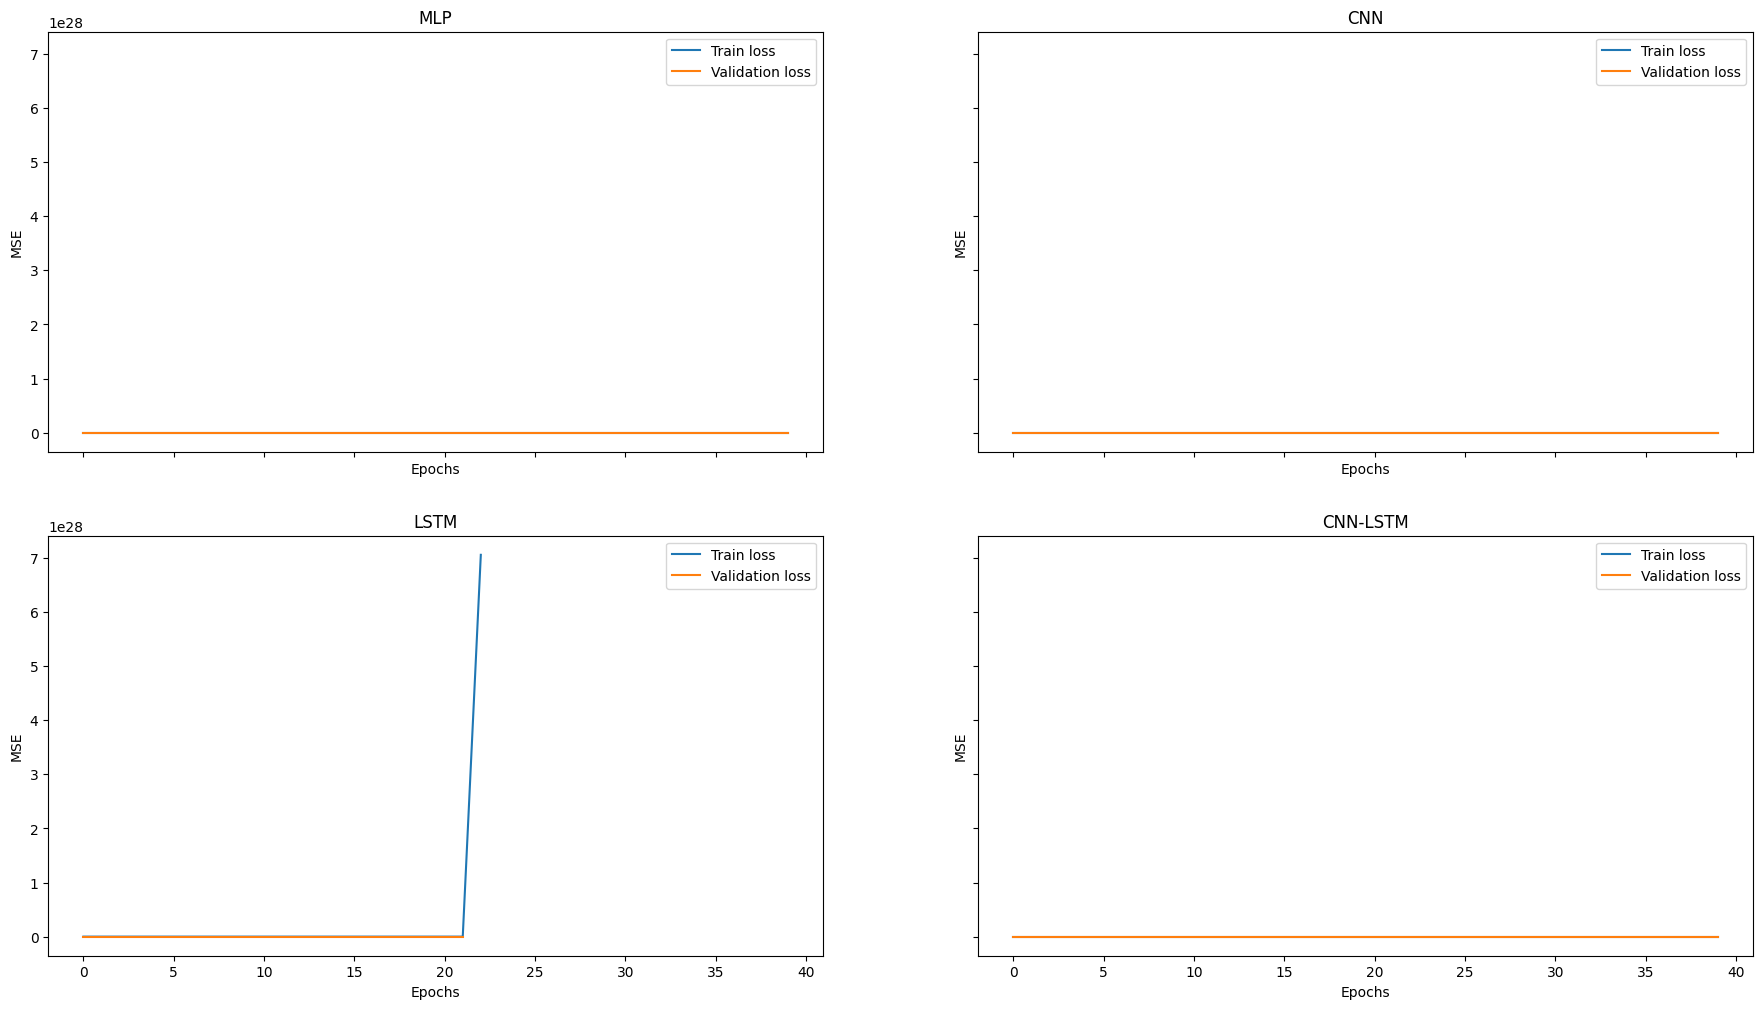

In [197]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

In [167]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

3/3 [==============================] - 0s 10ms/step
Train rmse: 0.08889349607040638
Validation rmse: 0.11898889808552314


In [168]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

3/3 [==============================] - 0s 21ms/step
Train rmse: 0.06321409516119325
Validation rmse: 0.06981270689087991


In [169]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

3/3 [==============================] - 1s 148ms/step
Train rmse: 0.11590105397553192
Validation rmse: 0.08163381629268371


In [170]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

3/3 [==============================] - 0s 19ms/step
Train rmse: 0.09754621391710698
Validation rmse: 0.08533454337002798


In [174]:
list_hasil = []
last_index =  train.iloc[-1].name
subsequences = 2
for x in range(last_index, len(df)):
    data = pd.DataFrame(df.iloc[x-window-1:x].sales.to_list()).transpose()
    data_scaled = pd.DataFrame(scaler.transform(data))
    data_series = data_scaled.values.reshape((data.shape[0], data.shape[1], 1))
    timesteps = data_series.shape[1]//subsequences
    data_series_sub = data_series.reshape((data_series.shape[0], subsequences, timesteps, 1))
    hasil = model_cnn_lstm.predict(data_series_sub)
    list_hasil.append(scaler_.inverse_transform(hasil)[0][0])

1/1 [==============================] - 0s 189ms/step


In [198]:
list_hasil = []
last_index =  train.iloc[-1].name
subsequences = 2
for x in range(last_index, len(df)):
    data = pd.DataFrame(df.iloc[x-window-1:x].sales.to_list()).transpose()
    data_scaled = pd.DataFrame(scaler.transform(data))
    data_series = data_scaled.values.reshape((data.shape[0], data.shape[1], 1))
    hasil = model_cnn.predict(data_series)
    list_hasil.append(scaler_.inverse_transform(hasil)[0][0])

1/1 [==============================] - 0s 117ms/step


In [178]:
list_hasil = []
last_index =  train.iloc[-1].name
for x in range(last_index, len(df)):
    data = pd.DataFrame(df.iloc[x-window-1:x].sales.to_list()).transpose()
    hasil = model_mlp.predict(data)
    list_hasil.append(hasil[0][0])

1/1 [==============================] - 0s 134ms/step


In [85]:
list_forecast = []
prior_data = df.iloc[len(df)-(window+1):len(df)].sales.to_list()
range_forecast = 10

for x in range(range_forecast):
    data = pd.DataFrame(prior_data[x:]).transpose()
    data_scaled = pd.DataFrame(scaler.transform(data))
    data_series = data_scaled.values.reshape((data.shape[0], data.shape[1], 1))
    timesteps = data_series.shape[1]//subsequences
    data_series_sub = data_series.reshape((data_series.shape[0], subsequences, timesteps, 1))
    hasil = model_cnn_lstm.predict(data_series_sub)
    list_forecast.append(scaler_.inverse_transform(hasil)[0][0])
    prior_data.append(hasil[0][0])

1/1 [==============================] - 0s 115ms/step


In [181]:
list_forecast = []
prior_data = df.iloc[len(df)-(window+1):len(df)].sales.to_list()
range_forecast = 10

for x in range(range_forecast):
    data = pd.DataFrame(prior_data[x:]).transpose()
    data_scaled = pd.DataFrame(scaler.transform(data))
    data_series = data_scaled.values.reshape((data.shape[0], data.shape[1], 1))
    hasil = model_cnn.predict(data_series)
    list_forecast.append(scaler_.inverse_transform(hasil)[0][0])
    prior_data.append(hasil[0][0])

1/1 [==============================] - 0s 74ms/step


In [240]:
list_forecast = []
prior_data = df.iloc[len(df)-(window+1):len(df)].sales.to_list()
range_forecast = 10

for x in range(range_forecast):
    data = pd.DataFrame(prior_data[x:]).transpose()
    hasil = model_mlp.predict(data)
    list_forecast.append(hasil[0][0])
    prior_data.append(hasil[0][0])

1/1 [==============================] - 0s 111ms/step


In [60]:
from datetime import timedelta

start_date  = test.iloc[-1].weekly_start_date
date_list = []

for i in range(range_forecast):
    date_list.append(start_date + timedelta(days=(i+1)*7))

In [182]:
#check test result
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score

print('r2 score ', r2_score(list_hasil, df['sales'].iloc[last_index:].to_list()))
print('explained variance score ', explained_variance_score(list_hasil, df['sales'].iloc[last_index:].to_list()))
print('MAE ', mean_absolute_error(list_hasil, df['sales'].iloc[last_index:].to_list()))

r2 score  -1.7437767314194677
explained variance score  -0.43800500200669235
MAE  6782554855.207916


Best one so far: CNN Model

In [183]:
import plotly.express as px

color_map = {'test_data': 'green', 'predict_data': 'black', 'forecast_data': 'red'}

df['category'] = 'test_data'
daily_trx_sc = px.line(df, x='weekly_start_date', y='sales', color='category', color_discrete_map=color_map)

df_predict = pd.DataFrame({'sales': list_hasil})
df_predict['weekly_start_date'] = df.iloc[last_index:]['weekly_start_date'].to_list()
df_predict['category'] = 'predict_data'
predict_sc = px.line(df_predict, x='weekly_start_date', y='sales', color='category', color_discrete_map=color_map)

df_forecast = pd.DataFrame({'sales': list_forecast, 'weekly_start_date': date_list})
df_forecast['category'] = 'forecast_data'
forecast_sc = px.line(df_forecast, x='weekly_start_date', y='sales', color='category', color_discrete_map=color_map)

layout = go.Layout(title='Weekly transactions', xaxis=dict(title='Date'), yaxis=dict(title='Trx count'))
fig = go.Figure(data=daily_trx_sc.data + predict_sc.data + forecast_sc.data)
fig.show()

# Tuning CNN Model

In [15]:
model_cnn_tuned = Sequential()
model_cnn_tuned.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_tuned.add(MaxPooling1D(pool_size=2))
model_cnn_tuned.add(Flatten())
model_cnn_tuned.add(Dense(50, activation='relu'))
model_cnn_tuned.add(Dense(1))
model_cnn_tuned.compile(loss='mse', optimizer=adam)
model_cnn_tuned.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 27, 64)            256       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 832)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                41650     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 41,957
Trainable params: 41,957
Non-trainable params: 0
__________________________________________________

In [69]:
cnn_history = model_cnn_tuned.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
5/5 - 20s - loss: 0.0502 - val_loss: 0.0209 - 20s/epoch - 4s/step
Epoch 2/40
5/5 - 2s - loss: 0.0221 - val_loss: 0.0095 - 2s/epoch - 453ms/step
Epoch 3/40
5/5 - 2s - loss: 0.0184 - val_loss: 0.0098 - 2s/epoch - 398ms/step
Epoch 4/40
5/5 - 3s - loss: 0.0159 - val_loss: 0.0082 - 3s/epoch - 619ms/step
Epoch 5/40
5/5 - 3s - loss: 0.0147 - val_loss: 0.0082 - 3s/epoch - 648ms/step
Epoch 6/40
5/5 - 3s - loss: 0.0137 - val_loss: 0.0076 - 3s/epoch - 580ms/step
Epoch 7/40
5/5 - 2s - loss: 0.0128 - val_loss: 0.0078 - 2s/epoch - 417ms/step
Epoch 8/40
5/5 - 3s - loss: 0.0122 - val_loss: 0.0075 - 3s/epoch - 533ms/step
Epoch 9/40
5/5 - 2s - loss: 0.0112 - val_loss: 0.0085 - 2s/epoch - 307ms/step
Epoch 10/40
5/5 - 2s - loss: 0.0113 - val_loss: 0.0069 - 2s/epoch - 336ms/step
Epoch 11/40
5/5 - 2s - loss: 0.0104 - val_loss: 0.0069 - 2s/epoch - 439ms/step
Epoch 12/40
5/5 - 7s - loss: 0.0097 - val_loss: 0.0071 - 7s/epoch - 1s/step
Epoch 13/40
5/5 - 5s - loss: 0.0094 - val_loss: 0.0065 - 5s/epoch

In [31]:
cnn_tuned_train_pred = model_cnn_tuned.predict(X_train_series)
cnn_tuned_valid_pred = model_cnn_tuned.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_tuned_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_tuned_valid_pred)))

3/3 [==============================] - 0s 16ms/step
Train rmse: 0.054107346068907144
Validation rmse: 0.0767531689624263


In [71]:
list_hasil_tuned = []
last_index =  train.iloc[-1].name
subsequences = 2
for x in range(last_index, len(df)):
    data = pd.DataFrame(df.iloc[x-window-1:x].sales.to_list()).transpose()
    data_scaled = pd.DataFrame(scaler.transform(data))
    data_series = data_scaled.values.reshape((data.shape[0], data.shape[1], 1))
    hasil = model_cnn_tuned.predict(data_series)
    list_hasil_tuned.append(scaler_.inverse_transform(hasil)[0][0])

1/1 [==============================] - 0s 179ms/step


In [33]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score

print('r2 score ', r2_score(list_hasil_tuned, df['sales'].iloc[last_index:].to_list()))
print('explained variance score ', explained_variance_score(list_hasil_tuned, df['sales'].iloc[last_index:].to_list()))
print('MAE ', mean_absolute_error(list_hasil_tuned, df['sales'].iloc[last_index:].to_list()))

r2 score  -1.0265139897333135
explained variance score  -0.2378921182844882
MAE  6563712900.124583


In [34]:
import plotly.express as px

color_map = {'test_data': 'green', 'predict_data': 'black', 'forecast_data': 'red'}

df['category'] = 'test_data'
daily_trx_sc = px.line(df, x='weekly_start_date', y='sales', color='category', color_discrete_map=color_map)

df_predict = pd.DataFrame({'sales': list_hasil_tuned})
df_predict['weekly_start_date'] = df.iloc[last_index:]['weekly_start_date'].to_list()
df_predict['category'] = 'predict_data'
predict_sc = px.line(df_predict, x='weekly_start_date', y='sales', color='category', color_discrete_map=color_map)

layout = go.Layout(title='Weekly transactions', xaxis=dict(title='Date'), yaxis=dict(title='Trx count'))
fig = go.Figure(data=daily_trx_sc.data + predict_sc.data)
fig.show()

# Monthly Sales + Holiday Exclude Covid

In [309]:
df = pd.read_csv('trx_2023_8_14.csv')
df['created'] = pd.to_datetime(df['created'], format='mixed')
df = df[(df['created']>pd.to_datetime('2014-01-01 00:00:00+00:00')) & (df['created']<pd.to_datetime('2023-06-01 00:00:00+00:00'))]
df['year_month'] = df['created'].dt.to_period('M')
df = df.groupby('year_month', as_index=False)['value'].sum()

In [310]:
df.rename(columns={'value':'sales'}, inplace=True)
df['year_month_str'] = df['year_month'].astype(str)

df['is_new_year'] = 0
new_year_date = ['2014-01','2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01']
df.loc[df['year_month_str'].isin(new_year_date),'is_new_year'] = 1

df['is_christmas'] = 0
christmas_date = ['2014-12','2015-12','2016-12','2017-12','2018-12','2019-12','2020-12','2021-12','2022-12','2023-12']
df.loc[df['year_month_str'].isin(christmas_date),'is_christmas'] = 1

df['is_ramadan'] = 0
ramadan_date = ['2014-07','2015-07','2016-06','2017-06','2018-06','2019-05','2020-05','2021-05','2022-04','2023-04']
df.loc[df['year_month_str'].isin(ramadan_date),'is_ramadan'] = 1

In [311]:
# exclude covid
covid_timeline = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
                  '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12']
df_noncovid = df[~df['year_month_str'].isin(covid_timeline)].reset_index().drop(columns='index')

In [312]:
end_period_train = start_period_test = pd.Period('2023-01', freq='M')

train = df_noncovid[(df_noncovid['year_month'] < end_period_train)]
test = df_noncovid[(df_noncovid['year_month'] >= start_period_test)]

In [ ]:
def series_to_supervised_holiday(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    holiday_columns = ['is_christmas','is_new_year','is_ramadan']
    data_ = data.drop(columns=holiday_columns)
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data_.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data_.columns]
    # Current timestep (t=0)
    cols.append(data_)
    names += [('%s(t)' % (col)) for col in data_.columns]
    # Target timestep (t=lag)
    cols.append(data_.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data_.columns]
    # add holiday target
    cols.append(data.shift(-lag)[holiday_columns])
    names += holiday_columns
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [313]:
window = 25
lag = 1
series = series_to_supervised_holiday(train.drop(columns=['year_month','year_month_str'], axis=1), window=window, lag=lag)
series.head()

# Label
labels_col = 'sales(t+%d)' % 1
labels = pd.DataFrame(series[labels_col])
series = series.drop(labels_col, axis=1)

# scalling X and Y
holiday_columns = ['is_christmas','is_new_year','is_ramadan']

scaler = MinMaxScaler()
scaler.fit(series.drop(columns=holiday_columns))
series_scaled = scaler.transform(series.drop(columns=holiday_columns))
X_scaled = pd.DataFrame(series_scaled)
X_scaled = pd.concat([X_scaled, series[holiday_columns].reset_index()], axis=1).drop(columns=['index'])

scaler_ = MinMaxScaler()
scaler_.fit(labels)
labels_scaled = scaler_.transform(labels)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_scaled, pd.DataFrame(labels_scaled), test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (34, 29)
Validation set shape (24, 29)


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,is_christmas,is_new_year,is_ramadan
54,0.286102,0.296841,0.253787,0.267296,0.284416,0.623322,0.514497,0.201603,0.338912,0.283898,...,0.161189,0.303499,1.000000,0.327145,0.276811,0.375114,0.275253,0.0,0.0,0.0
26,0.076442,0.107074,0.205886,0.623222,0.458813,0.106777,0.065688,0.095797,0.129862,0.236471,...,0.128457,0.129807,0.315042,0.267887,0.150056,0.181051,0.179692,0.0,0.0,0.0
15,0.036713,0.126034,0.222760,0.610314,0.080999,0.016427,0.042726,0.056860,0.184999,0.230517,...,0.112803,0.206340,0.245465,0.000000,0.068375,0.104669,0.163547,0.0,0.0,1.0
5,0.100887,0.559009,0.051328,0.042088,0.003910,0.008003,0.124195,0.117990,0.050369,0.000000,...,0.201116,0.069819,0.048925,0.071536,0.144699,0.452643,0.334620,0.0,0.0,0.0
30,0.463479,0.114480,0.073391,0.122153,0.155698,0.283517,0.336981,0.001295,0.079226,0.120591,...,0.150056,0.181051,0.179692,0.365307,0.730658,0.203688,0.211615,0.0,0.0,0.0


In [314]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (34, 29, 1)
Validation set shape (24, 29, 1)


In [346]:
model_cnn_tuned = Sequential()
model_cnn_tuned.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_tuned.add(MaxPooling1D(pool_size=2))
model_cnn_tuned.add(Flatten())
model_cnn_tuned.add(Dense(50, activation='relu'))
model_cnn_tuned.add(Dense(1))
model_cnn_tuned.compile(loss='mse', optimizer=adam)
model_cnn_tuned.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 28, 256)           768       
                                                                 
 max_pooling1d_32 (MaxPoolin  (None, 14, 256)          0         
 g1D)                                                            
                                                                 
 flatten_32 (Flatten)        (None, 3584)              0         
                                                                 
 dense_67 (Dense)            (None, 50)                179250    
                                                                 
 dense_68 (Dense)            (None, 1)                 51        
                                                                 
Total params: 180,069
Trainable params: 180,069
Non-trainable params: 0
_______________________________________________

In [347]:
cnn_history = model_cnn_tuned.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=40, verbose=2)
cnn_tuned_train_pred = model_cnn_tuned.predict(X_train_series)
cnn_tuned_valid_pred = model_cnn_tuned.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_tuned_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_tuned_valid_pred)))

Epoch 1/40


2/2 - 12s - loss: 0.1226 - val_loss: 0.0288 - 12s/epoch - 6s/step
Epoch 2/40
2/2 - 1s - loss: 0.0569 - val_loss: 0.0139 - 853ms/epoch - 426ms/step
Epoch 3/40
2/2 - 1s - loss: 0.0346 - val_loss: 0.0219 - 779ms/epoch - 390ms/step
Epoch 4/40
2/2 - 1s - loss: 0.0352 - val_loss: 0.0141 - 545ms/epoch - 272ms/step
Epoch 5/40
2/2 - 1s - loss: 0.0271 - val_loss: 0.0083 - 765ms/epoch - 383ms/step
Epoch 6/40
2/2 - 1s - loss: 0.0215 - val_loss: 0.0086 - 807ms/epoch - 404ms/step
Epoch 7/40
2/2 - 1s - loss: 0.0212 - val_loss: 0.0100 - 711ms/epoch - 356ms/step
Epoch 8/40
2/2 - 1s - loss: 0.0214 - val_loss: 0.0108 - 1s/epoch - 620ms/step
Epoch 9/40
2/2 - 1s - loss: 0.0201 - val_loss: 0.0103 - 815ms/epoch - 407ms/step
Epoch 10/40
2/2 - 0s - loss: 0.0171 - val_loss: 0.0093 - 388ms/epoch - 194ms/step
Epoch 11/40
2/2 - 0s - loss: 0.0127 - val_loss: 0.0094 - 228ms/epoch - 114ms/step
Epoch 12/40
2/2 - 0s - loss: 0.0103 - val_loss: 0.0121 - 367ms/epoch - 183ms/step
Epoch 13/40
2/2 - 1s - loss: 0.0102 - val_l

In [348]:
list_hasil = []
last_index =  train.iloc[-1].name
subsequences = 2
for x in range(last_index, len(df_noncovid)):
    data = pd.DataFrame(df_noncovid.iloc[x-window-1:x].sales.to_list()).transpose()
    data_scaled = pd.DataFrame(scaler.transform(data))
    data_scaled['is_christmas'] = df_noncovid.loc[x, 'is_christmas']
    data_scaled['is_new_year'] = df_noncovid.loc[x, 'is_new_year']
    data_scaled['is_ramadan'] = df_noncovid.loc[x, 'is_ramadan']
    data_series = data_scaled.values.reshape((data_scaled.shape[0], data_scaled.shape[1], 1))
    hasil = model_cnn_tuned.predict(data_series)
    list_hasil.append(scaler_.inverse_transform(hasil)[0][0])

print('r2 score ', r2_score(list_hasil, df_noncovid['sales'].iloc[last_index:].to_list()))
print('explained variance score ', explained_variance_score(list_hasil, df_noncovid['sales'].iloc[last_index:].to_list()))
print('MAE ', mean_absolute_error(list_hasil, df_noncovid['sales'].iloc[last_index:].to_list()))

1/1 [==============================] - 2s 2s/step
r2 score  -0.20317535371234152
explained variance score  0.6199333434048732
MAE  23103156009.335003


In [349]:
list_forecast = []
prior_data = df.iloc[len(df)-(window+1):len(df)].sales.to_list()
range_forecast = 3

for x in range(range_forecast):
    data = pd.DataFrame(prior_data[x:]).transpose()
    data_scaled = pd.DataFrame(scaler.transform(data))
    data_scaled['is_christmas'] = 0
    data_scaled['is_new_year'] = 0
    data_scaled['is_ramadan'] = 0
    data_series = data_scaled.values.reshape((data_scaled.shape[0], data_scaled.shape[1], 1))
    
    hasil = model_cnn_tuned.predict(data_series)
    list_forecast.append(scaler_.inverse_transform(hasil)[0][0])
    prior_data.append(scaler_.inverse_transform(hasil)[0][0])

1/1 [==============================] - 0s 146ms/step


In [350]:
import plotly.express as px

color_map = {'train_data': 'green', 'test_data': 'black', 'forecast_data': 'red'}

df['category'] = 'train_data'
monthly_trx_sc = px.line(df, x='year_month_str', y='sales', color='category', color_discrete_map=color_map)

df_predict = pd.DataFrame({'sales': list_hasil})
df_predict['year_month_str'] = df_noncovid.iloc[last_index:]['year_month_str'].to_list()
df_predict['category'] = 'test_data'
predict_sc = px.line(df_predict, x='year_month_str', y='sales', color='category', color_discrete_map=color_map)

df_forecast = pd.DataFrame({'sales': list_forecast, 'year_month_str': ['2023-06', '2023-07', '2023-08']})
df_forecast['category'] = 'forecast_data'
forecast_sc = px.line(df_forecast, x='year_month_str', y='sales', color='category', color_discrete_map=color_map)

layout = go.Layout(title='Monthly sales', xaxis=dict(title='Date'), yaxis=dict(title='Trx count'))
fig = go.Figure(data=monthly_trx_sc.data + predict_sc.data + forecast_sc.data)
fig.show()

# Monthly Trx Count + Holiday Exclude Covid 

In [294]:
df = pd.read_csv('trx_2023_8_14.csv')
df['created'] = pd.to_datetime(df['created'], format='mixed')
df = df[(df['created']>pd.to_datetime('2014-01-01 00:00:00+00:00')) & (df['created']<pd.to_datetime('2023-06-01 00:00:00+00:00'))] #datanya belum lengkap di bulan juni 2023
df['year_month'] = df['created'].dt.to_period('M')
df = df.groupby('year_month', as_index=False)['id'].count()

In [295]:
df.rename(columns={'id':'trx_count'}, inplace=True)
df['year_month_str'] = df['year_month'].astype(str)

df['is_new_year'] = 0
new_year_date = ['2014-01','2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01']
df.loc[df['year_month_str'].isin(new_year_date),'is_new_year'] = 1

df['is_christmas'] = 0
christmas_date = ['2014-12','2015-12','2016-12','2017-12','2018-12','2019-12','2020-12','2021-12','2022-12','2023-12']
df.loc[df['year_month_str'].isin(christmas_date),'is_christmas'] = 1

df['is_ramadan'] = 0
ramadan_date = ['2014-07','2015-07','2016-06','2017-06','2018-06','2019-05','2020-05','2021-05','2022-04','2023-04']
df.loc[df['year_month_str'].isin(ramadan_date),'is_ramadan'] = 1

# exclude covid
covid_timeline = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
                  '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12']
df_noncovid = df[~df['year_month_str'].isin(covid_timeline)].reset_index().drop(columns='index')

In [296]:
end_period_train = start_period_test = pd.Period('2023-01', freq='M')

train = df_noncovid[(df_noncovid['year_month'] < end_period_train)]
test = df_noncovid[(df_noncovid['year_month'] >= start_period_test)]

In [297]:
window = 25
lag = 1
series = series_to_supervised_holiday(train.drop(columns=['year_month','year_month_str'], axis=1), window=window, lag=lag)
series.head()

# Label
labels_col = 'trx_count(t+%d)' % 1
labels = pd.DataFrame(series[labels_col])
series = series.drop(labels_col, axis=1)

# scalling X and Y
holiday_columns = ['is_christmas','is_new_year','is_ramadan']

scaler = MinMaxScaler()
scaler.fit(series.drop(columns=holiday_columns))
series_scaled = scaler.transform(series.drop(columns=holiday_columns))
X_scaled = pd.DataFrame(series_scaled)
X_scaled = pd.concat([X_scaled, series[holiday_columns].reset_index()], axis=1).drop(columns=['index'])

scaler_ = MinMaxScaler()
scaler_.fit(labels)
labels_scaled = scaler_.transform(labels)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_scaled, pd.DataFrame(labels_scaled), test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (34, 29)
Validation set shape (24, 29)


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,is_christmas,is_new_year,is_ramadan
54,0.360192,0.346299,0.241177,0.246859,0.241113,0.616519,0.488699,0.176692,0.318736,0.260948,...,0.033023,0.163428,0.778909,0.191340,0.172471,0.296208,0.099626,0.0,0.0,0.0
26,0.058071,0.091033,0.220796,0.667828,0.539280,0.160146,0.063685,0.111779,0.170059,0.287572,...,0.151084,0.156487,0.419390,0.375409,0.167190,0.204683,0.215838,0.0,0.0,0.0
15,0.025408,0.110777,0.200200,0.644236,0.142592,0.030396,0.050544,0.070110,0.211080,0.300857,...,0.155205,0.274822,0.371760,0.000000,0.092318,0.149594,0.199534,0.0,0.0,1.0
5,0.104074,0.609907,0.086306,0.077749,0.011428,0.009582,0.128926,0.174783,0.070239,0.000000,...,0.288344,0.074891,0.040039,0.073241,0.203947,0.654229,0.525003,0.0,0.0,0.0
30,0.539535,0.160610,0.064203,0.113511,0.171948,0.290767,0.387059,0.017583,0.108277,0.164547,...,0.167190,0.204683,0.215838,0.451771,0.988816,0.344357,0.330363,0.0,0.0,0.0


In [298]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (34, 29, 1)
Validation set shape (24, 29, 1)


In [304]:
model_cnn_tuned = Sequential()
model_cnn_tuned.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_tuned.add(MaxPooling1D(pool_size=2))
model_cnn_tuned.add(Flatten())
model_cnn_tuned.add(Dense(50, activation='relu'))
model_cnn_tuned.add(Dense(1))
model_cnn_tuned.compile(loss='mse', optimizer=adam)
model_cnn_tuned.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_25 (Conv1D)          (None, 28, 256)           768       
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 14, 256)          0         
 g1D)                                                            
                                                                 
 flatten_25 (Flatten)        (None, 3584)              0         
                                                                 
 dense_53 (Dense)            (None, 50)                179250    
                                                                 
 dense_54 (Dense)            (None, 1)                 51        
                                                                 
Total params: 180,069
Trainable params: 180,069
Non-trainable params: 0
_______________________________________________

In [305]:
cnn_history = model_cnn_tuned.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=40, verbose=2)
cnn_tuned_train_pred = model_cnn_tuned.predict(X_train_series)
cnn_tuned_valid_pred = model_cnn_tuned.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_tuned_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_tuned_valid_pred)))

Epoch 1/40
2/2 - 9s - loss: 0.1434 - val_loss: 0.0786 - 9s/epoch - 4s/step
Epoch 2/40
2/2 - 0s - loss: 0.0891 - val_loss: 0.0419 - 201ms/epoch - 101ms/step
Epoch 3/40
2/2 - 1s - loss: 0.0599 - val_loss: 0.0322 - 701ms/epoch - 350ms/step
Epoch 4/40
2/2 - 0s - loss: 0.0504 - val_loss: 0.0281 - 464ms/epoch - 232ms/step
Epoch 5/40
2/2 - 1s - loss: 0.0449 - val_loss: 0.0254 - 543ms/epoch - 271ms/step
Epoch 6/40
2/2 - 1s - loss: 0.0403 - val_loss: 0.0233 - 786ms/epoch - 393ms/step
Epoch 7/40
2/2 - 0s - loss: 0.0363 - val_loss: 0.0217 - 484ms/epoch - 242ms/step
Epoch 8/40
2/2 - 1s - loss: 0.0329 - val_loss: 0.0217 - 759ms/epoch - 379ms/step
Epoch 9/40
2/2 - 1s - loss: 0.0300 - val_loss: 0.0226 - 1s/epoch - 728ms/step
Epoch 10/40
2/2 - 1s - loss: 0.0279 - val_loss: 0.0231 - 1s/epoch - 617ms/step
Epoch 11/40
2/2 - 1s - loss: 0.0251 - val_loss: 0.0218 - 1s/epoch - 516ms/step
Epoch 12/40
2/2 - 1s - loss: 0.0224 - val_loss: 0.0201 - 831ms/epoch - 415ms/step
Epoch 13/40
2/2 - 0s - loss: 0.0197 - va

In [306]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score

list_hasil = []
last_index =  train.iloc[-1].name
subsequences = 2
for x in range(last_index, len(df_noncovid)):
    data = pd.DataFrame(df_noncovid.iloc[x-window-1:x].trx_count.to_list()).transpose()
    data_scaled = pd.DataFrame(scaler.transform(data))
    data_scaled['is_christmas'] = df_noncovid.loc[x, 'is_christmas']
    data_scaled['is_new_year'] = df_noncovid.loc[x, 'is_new_year']
    data_scaled['is_ramadan'] = df_noncovid.loc[x, 'is_ramadan']
    data_series = data_scaled.values.reshape((data_scaled.shape[0], data_scaled.shape[1], 1))
    hasil = model_cnn_tuned.predict(data_series)
    list_hasil.append(scaler_.inverse_transform(hasil)[0][0])

print('r2 score ', r2_score(list_hasil, df_noncovid['trx_count'].iloc[last_index:].to_list()))
print('explained variance score ', explained_variance_score(list_hasil, df_noncovid['trx_count'].iloc[last_index:].to_list()))
print('MAE ', mean_absolute_error(list_hasil, df_noncovid['trx_count'].iloc[last_index:].to_list()))

1/1 [==============================] - 1s 506ms/step
r2 score  0.5217679229411514
explained variance score  0.6747449223107338
MAE  12729.663411458334


In [307]:
list_forecast = []
prior_data = df.iloc[len(df)-(window+1):len(df)].trx_count.to_list()
range_forecast = 3

for x in range(range_forecast):
    data = pd.DataFrame(prior_data[x:]).transpose()
    data_scaled = pd.DataFrame(scaler.transform(data))
    data_scaled['is_christmas'] = 0
    data_scaled['is_new_year'] = 0
    data_scaled['is_ramadan'] = 0
    data_series = data_scaled.values.reshape((data_scaled.shape[0], data_scaled.shape[1], 1))
    
    hasil = model_cnn_tuned.predict(data_series)
    list_forecast.append(scaler_.inverse_transform(hasil)[0][0])
    prior_data.append(scaler_.inverse_transform(hasil)[0][0])

1/1 [==============================] - 0s 488ms/step


In [308]:
import plotly.express as px

color_map = {'train_data': 'green', 'test_data': 'black', 'forecast_data': 'red'}

df['category'] = 'train_data'
monthly_trx_sc = px.line(df, x='year_month_str', y='trx_count', color='category', color_discrete_map=color_map)

df_predict = pd.DataFrame({'trx_count': list_hasil})
df_predict['year_month_str'] = df_noncovid.iloc[last_index:]['year_month_str'].to_list()
df_predict['category'] = 'test_data'
predict_sc = px.line(df_predict, x='year_month_str', y='trx_count', color='category', color_discrete_map=color_map)

df_forecast = pd.DataFrame({'trx_count': list_forecast, 'year_month_str': ['2023-06', '2023-07', '2023-08']})
df_forecast['category'] = 'forecast_data'
forecast_sc = px.line(df_forecast, x='year_month_str', y='trx_count', color='category', color_discrete_map=color_map)

layout = go.Layout(title='Monthly sales', xaxis=dict(title='Date'), yaxis=dict(title='Trx count'))
fig = go.Figure(data=monthly_trx_sc.data + predict_sc.data + forecast_sc.data, layout=layout)
fig.show()